In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Coursework1: Convolutional Neural Networks 

## Instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [2]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = in_channels
        self.F = out_channels

        if isinstance(kernel_size, int):
            self.HH = self.WW = kernel_size
        else:
            self.HH, self.WW = kernel_size
        
        self.stride = stride
        self.padding = padding

        self.w = torch.Tensor(self.F, self.C, self.HH, self.WW)

        # Weights and biases (if present) initialized close to zero but not too small
        self.w.normal_(mean=0, std=0.1)

        if bias:
            self.b = torch.Tensor(self.F, )
            self.b.normal_(mean=0, std=0.1)
        else:
            self.b = None



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape

        assert C == self.C, "Number of input channels is " + C + " (expected " + self.C + ")"

        # Output sizes
        H_out = int((H - self.HH + 2*self.padding)/self.stride) + 1
        W_out = int((W - self.WW + 2*self.padding)/self.stride) + 1

        assert H_out % 1 == 0, "Height of output is not integer"
        assert W_out % 1 == 0, "Width of output is not integer"

        H_out, W_out = int(H_out), int(W_out)

        x_unf = F.unfold(x, (self.HH, self.WW), dilation=1, padding=self.padding, stride=self.stride)

        out_unf = x_unf.transpose(1, 2) @ self.w.view(self.F, -1).transpose(1, 0)

        if self.b != None:
            out_unf += self.b

        out = out_unf.transpose(1,2).view(N, self.F, H_out, W_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [4]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, int):
            self.HH = self.WW = kernel_size
        else:
            self.HH, self.WW = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape

        # Output sizes
        H_out = H / self.HH
        W_out = W / self.WW

        assert H_out % 1 == 0, "Height of output is not integer"
        assert W_out % 1 == 0, "Width of output is not integer"

        H_out, W_out = int(H_out), int(W_out)

        x_unf = F.unfold(x, (self.HH, self.WW), stride=(self.HH, self.WW)).transpose(2,1)
        x_unf = x_unf.view(N, -1, C, self.HH*self.WW).transpose(2,1)

        out = torch.max(x_unf, 3)[0].view(N, C, H_out, H_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [5]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = in_channels
        self.F = out_channels
        
        self.w = torch.Tensor(self.C, self.F)

        # Weights and biases (if present) initialized close to zero but not too small
        self.w.normal_(mean=0, std=0.1)

        if bias:
            self.b = torch.Tensor(self.F, )
            self.b.normal_(mean=0, std=0.1)
        else:
            self.b = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, H = x.shape[0], x.shape[-1]

        assert H == self.C, "Number of input channels is " + H + " (expected " + self.C + ")"

        out = x @ self.w

        if self.b != None:
            out += self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [6]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.running_mean = 0
        self.running_var = 0

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape

        assert C == self.C, "Number of input channels is " + C + " (expected " + self.C + ")"

        if self.training:           
            mean = torch.mean(x, dim=(0,2,3))
            var = torch.var(x, dim=(0,2,3), unbiased=False)

            if self.running_mean is None:
                self.running_mean, self.running_var = mean, var
            else:
                self.running_mean = self.momentum*mean + (1-self.momentum)*self.running_mean
                self.running_var = self.momentum*var + (1-self.momentum)*self.running_var

        else:                       
            mean, var = self.running_mean, self.running_var

        x_norm = (x - mean.view(1,-1,1,1)) / (var.view(1,-1,1,1) + self.eps)**0.5
        
        x = x_norm * self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

4: Many approaches have been proposed in literature for hyperparameter searching. One of the most widely adopted methods is Grid Search, i.e. the exhaustive search of the best combination of hyperparameters in a manually specified subset of the hyperparameter space. The major obstacle with this approach is that it rapidly becomes computationally expensive as the number of combinations increases.

Alternative strategies that could have been applied include Random Search and Bayesian Optimisation. Random Search tries many different combinations of hyperparameters randomly sampled from a predefined subset of the hyperparameter space. After a number of attempts, the best performing combination is returned. In Bayesian Optimisation, a probabilistic model is built to estimate the function we want to optimize. As the number of observations grows, the algorithm becomes more certain of which regions in the hyperparameter space are worth exploring and which are not. In particular, this method is useful in those contexts where it is too expensive to compute an exhaustive search.

Given the relatively manageable size of the model, and the limited number of epochs, the most suited strategy for this specific problem is Grid Search. In the case where there was no cap on the number of epochs or the amount of data was significantly larger, it would have been preferable to opt for a Bayesian Optimisation.


In [7]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [8]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

def create_transforms(rand_crop=True, rand_horiz_flip=True, rand_aff=True):
    """
    This function returns a composition of transforms as specified from input so 
    that it can be included in the grid search. Transforms always include conversion 
    to tensor and normalization.
    Input:
    - rand_crop: flag for random cropping (default: True)
    - rand_horiz_flip: flag for random horizontal flip (default: True)
    - rand_aff: flag for random affine transformation (default: True)
    Output:
    - transforms: dictionary of train and test transformations
    """ 

    transforms = {}

    train = []
    test = []

    default_operations = [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
    ]
    
    if rand_horiz_flip:
        train.append(T.RandomHorizontalFlip(p=0.5))

    if rand_crop:
        train.append(T.RandomResizedCrop(size=(28,28)))

    if rand_aff:
        train.append(T.RandomAffine(5, scale=(0.9,1.1)))

    train.extend(default_operations)
    test.extend(default_operations)

    transforms['train'] = T.Compose(train)
    transforms['test'] = T.Compose(test)

    return transforms

transforms = create_transforms()


##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [15]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

from sklearn.model_selection import train_test_split

def load_data(transforms, batch_size=64, val=True):
    """
    This function returns a loader for each data split. The validation split is 
    optional. If not present, all training data is used for the train split.
    Input:
    - transforms: the transforms to be applied when loading data
    - batch_size: number of elements per batch (default: 64)
    - val: flag for validation split (default: True)
    Output:
    - loader_train: loader for training data
    - loader_val: loader for validation data (can be None)
    - loader_test: loader for test data
    """

    data_dir = './data'

    cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transforms['train'])

    # Stratified splitting to guarantee proper distribution of each class in both train and val splits
    train_idx, val_idx = train_test_split(range(len(cifar10_train.targets)), test_size=0.1, shuffle=True, stratify=cifar10_train.targets)

    if val:
        loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(train_idx))
        cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transforms['test'])
        loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(val_idx))
    else:
        loader_train = DataLoader(cifar10_train, batch_size=batch_size)
        loader_val = None

    cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transforms['test'])
    loader_test = DataLoader(cifar10_test, batch_size=batch_size)

    return loader_train, loader_val, loader_test

loader_train, loader_val, loader_test = load_data(transforms)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

    return acc

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                # Small edit to original code to print mean validation or test loss
                if loader_val:
                    model.eval()
                    with torch.no_grad():
                        val_loss = 0
                        for x, y in loader_val:
                            x = x.to(device=device, dtype=dtype)
                            y = y.to(device=device, dtype=torch.long)
                            scores = model(x)
                            val_loss += F.cross_entropy(scores, y)
                        val_loss = val_loss / len(loader_val)
                        print('Epoch: %d, Iteration %d, train loss = %.4f, validation loss = %.4f' % (e, t, loss.item(), val_loss))
                else:
                    model.eval()
                    with torch.no_grad():
                        test_loss = 0
                        for x, y in loader_test:
                            x = x.to(device=device, dtype=dtype)
                            y = y.to(device=device, dtype=torch.long)
                            scores = model(x)
                            test_loss += F.cross_entropy(scores, y)
                        test_loss = test_loss / len(loader_test)
                        print('Epoch: %d, Iteration %d, train loss = %.4f, test loss = %.4f' % (e, t, loss.item(), test_loss))
                #check_accuracy(loader_val, model)
                #print()

In [14]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

from itertools import product
from os.path import isfile
import pickle

"""
Here I perform a grid search over many hyperparameters configurations to find
the optimal configuration. Each model configuration is trained with the train split 
and evaluated with the validation split. Progresses are saved in a pickle file and 
resumed if stopped.

When the search has been completed, the optimal configuration is used to train
the model and performance is assessed on an held-out test set.
"""

saver = "/content/gdrive/My Drive/progress_saver.p"

# Experimental optimal configuration, overwritten if grid search is performed
best_config = (0.001, 64, False, False, False, True, True)

# Set to True to perform grid search
perform_grid_search = False

if perform_grid_search:
    best_acc_so_far = 0
    saved_progress = {}

    params = {
        'lr':[0.0005, 0.001, 0.005],
        'batch_size':[64,32,16],
        'rand_crop':[False, True],
        'rand_horiz_flip':[False, True],
        'rand_aff':[False, True],
        'sched':[False, True],
        'amsgrad':[False, True]
    }

    # Create list of all possible configurations
    configs = list(product(*list(params.values())))

    total = len(configs)

    # Resume if already started, start from scratch otherwise
    if isfile(saver):
        with open(saver, 'rb') as fp:
            saved_progress = pickle.load(fp)

        configs = [config for config in configs if config not in saved_progress]

        best_config = max(saved_progress, key=saved_progress.get)
        best_acc_so_far = saved_progress[best_config]

        print(f"Resuming grid search ({total - len(configs)} of {total})...")
        print()

    accuracies = saved_progress
    for config in configs:
        lr, batch_size, rand_crop, rand_horiz_flip, rand_aff, sched, amsgrad = config
        
        print('='*25)
        print(f'Configuration: lr = {lr}, batch size = {batch_size}, ', \
            f'rand_crop = {rand_crop}, rand_horiz_flip = {rand_horiz_flip}, rand_aff = {rand_aff},', \
            f'scheduler = {sched}, amsgrad = {amsgrad}')
        print()

        transforms = create_transforms(rand_crop, rand_horiz_flip, rand_aff)
        loader_train, loader_val, loader_test = load_data(transforms, batch_size)

        model = ResNet18()
        optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=amsgrad)

        if sched:
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8, last_epoch=-1)

        train_part(model, optimizer, epochs=10)

        print('='*25)
        accuracies[config] = check_accuracy(loader_val, model)
        print()

        with open(saver, 'wb') as fp:
            pickle.dump(accuracies, fp, protocol=pickle.HIGHEST_PROTOCOL)

        if accuracies[config] > best_acc_so_far:
            best_acc_so_far = accuracies[config]
            best_config = config
            torch.save(model.state_dict(), "/content/gdrive/My Drive/best_model.pt")

    print("Grid search completed.")
    print()
    print("="*25)
    print()

lr, batch_size, rand_crop, rand_horiz_flip, rand_aff, scheduler, amsgrad = best_config

transforms = create_transforms(rand_crop, rand_horiz_flip, rand_aff)
loader_train, loader_val, loader_test = load_data(transforms, batch_size, val=False)

model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=amsgrad)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8, last_epoch=-1)


##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), "/content/gdrive/My Drive/final_model.pt")

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, Iteration 0, train loss = 3.9613, test loss = 2.3024
Epoch: 0, Iteration 100, train loss = 1.8033, test loss = 1.7208
Epoch: 0, Iteration 200, train loss = 1.3988, test loss = 1.3491
Epoch: 0, Iteration 300, train loss = 1.1015, test loss = 1.3959
Epoch: 0, Iteration 400, train loss = 1.2129, test loss = 1.1737
Epoch: 0, Iteration 500, train loss = 1.3938, test loss = 1.2415
Epoch: 0, Iteration 600, train loss = 0.8811, test loss = 0.9600
Epoch: 0, Iteration 700, train loss = 1.1889, test loss = 1.1230
Epoch: 1, Iteration 0, train loss = 0.7600, test loss = 1.0376
Epoch: 1, Iteration 100, train loss = 0.7835, test loss = 0.8449
Epoch: 1, Iteration 200, train loss = 0.6251, test loss = 0.9012
Epoch: 1, Iteration 300, train loss = 0.7619, test loss = 0.7589
Epoch: 1, Iteration 400, train loss = 0.7535, test loss = 0.6867
Epoch: 1, Iteration 500, train loss = 0.9817, test loss = 0.8148
Epoch: 1, Iteratio

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

1: Observing the feature maps below, we notice that the low-levels of the network detect local pattern-looking features (i.e. lines, edges, etc), while high-level layers become more and more abstract. Intuitively, we can understand this behaviour because higher-level features are compositions of lower-level features, which makes them more and more complex layer after layer, with layer 4 giving the most abstract representations. This pattern was to be expected, as the features from the image get abstracted into more general concepts in order to make the classification.

2: The accuracy of the model on the test set is 86.1%, which indicates that the model is generalizing well enough on unseen data. As discussed in the next question, class-specific accuracies would give more insights about the generalization abilities of the model. Analysing the training log, we can see that validation loss is still improving after ten epochs. This indicates that the model is not yet overfitting to the training data and that the performance could be improved by further training. An interesting observation is that, although some feature maps look similar to each other, most of them capture different features and produce different activations. This phenomenon is particularly noticeable in low-level feature maps. This observation suggests that the model is well-sized for the given task. Moreover, if we compare the feature maps generated by filters learned from different initializations, we can observe that they are relatable. This is a good sign because it means that the number of filters is sufficient for the problem.

To further improve performance, we could explore different configurations of Resnet that are better suited for the CIFAR10 task, such as Resnet20. Another option could be to use transfer learning, which is a technique where a large network is pre-trained on a sizable dataset and fine-tuned for the given task. Moreover, a combination of further data augmentations and training would improve performance.

3: Another possible approach for analysing the performance of the model would be to adopt cross-validation. This method requires to split the training data in k folds and iteratively use k-1 folds for training and 1 fold for validation. This process is repeated until all folds have been used for validation. Then, the resulting accuracies are averaged. By following this approach, we would obtain a more reliable estimate of the generalization abilities of the model. The main problem with this approach is that it rapidly becomes computationally expensive.

Moreover, a more detailed inspection of the class-specific performances could be carried out by analysing a confusion matrix and deriving measures such as precision and recall for each class separately. This approach would help us understand if the model is significantly better or worst at classifying certain classes.

Another interesting approach would be to test the accuracy of the model on certain transformations of the test images such as by adding a small amount of Gaussian noise or translating/rotating the images. This approach could be particularly useful for understanding the generalization ability of the model. For instance, if the model performs badly after adding an imperceptible amount of Gaussian noise to the images, it would be a sign of overfitting.




Files already downloaded and verified


<Figure size 432x288 with 0 Axes>

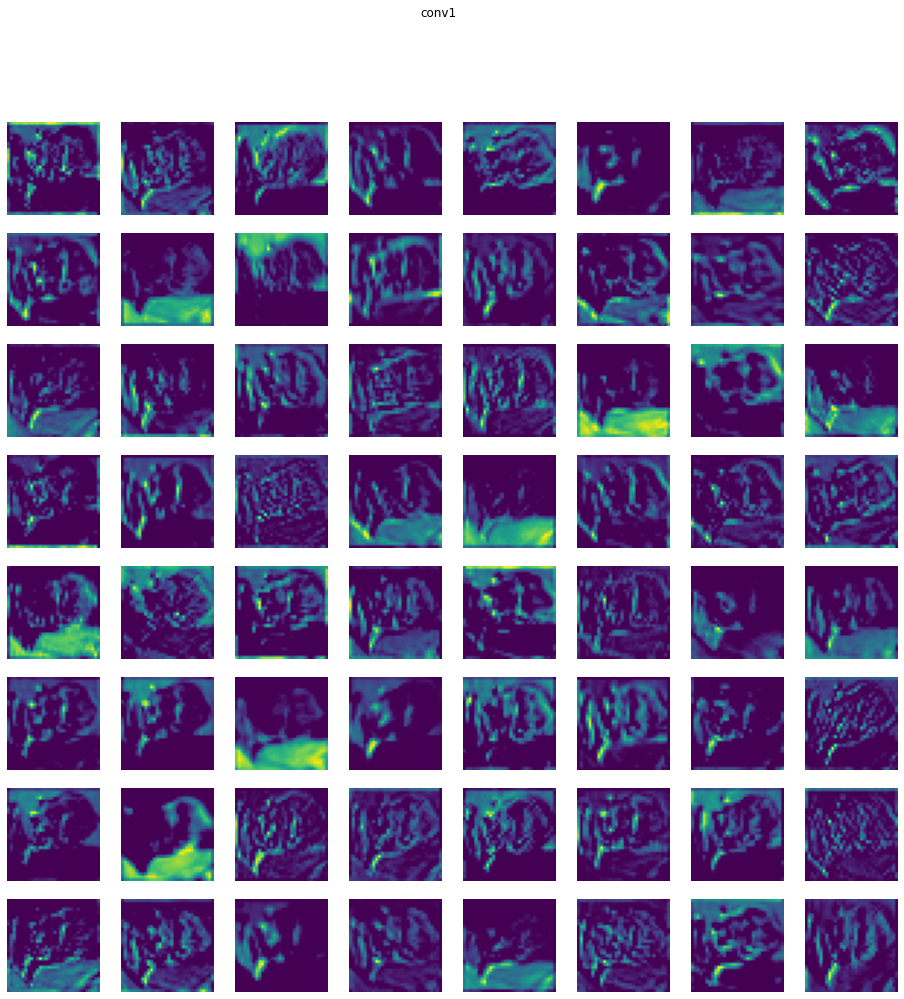

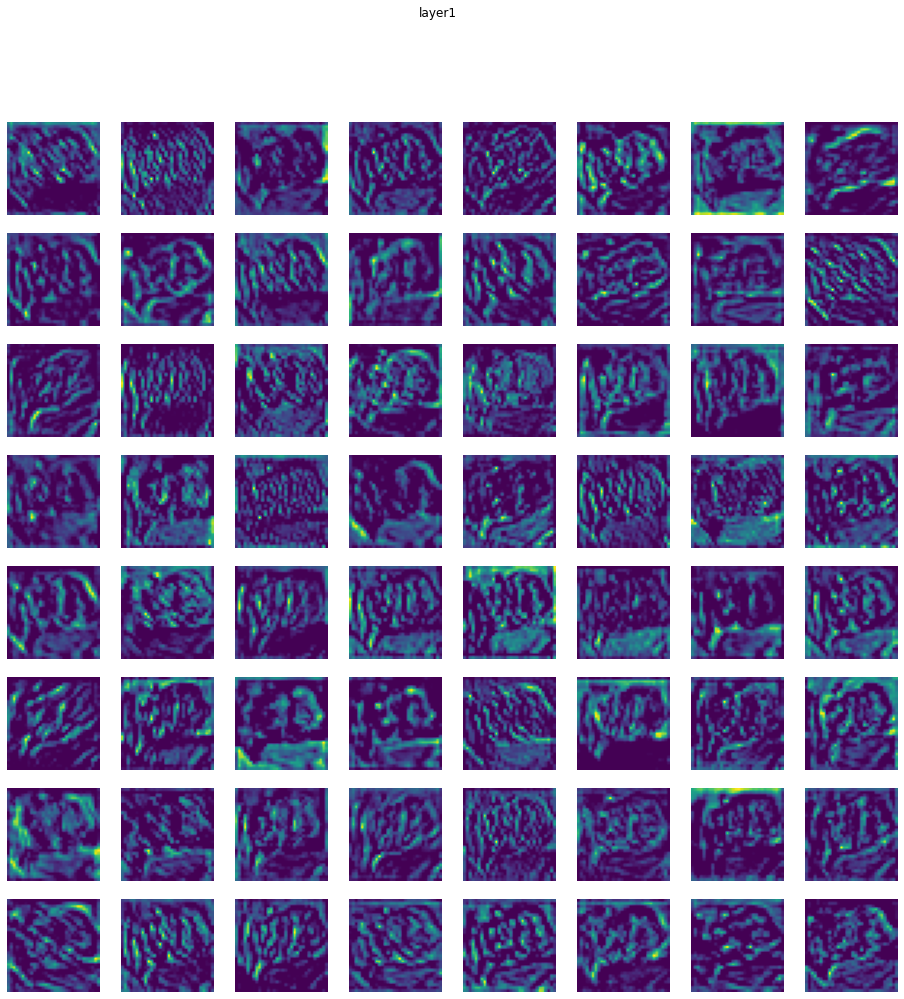

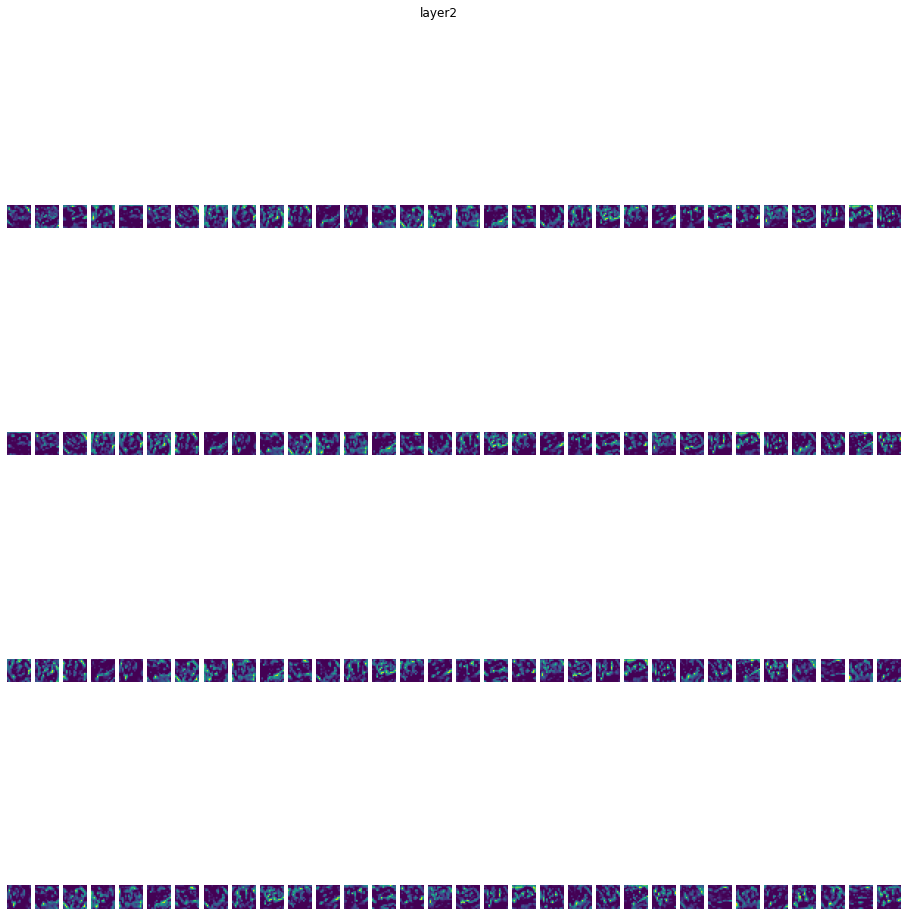

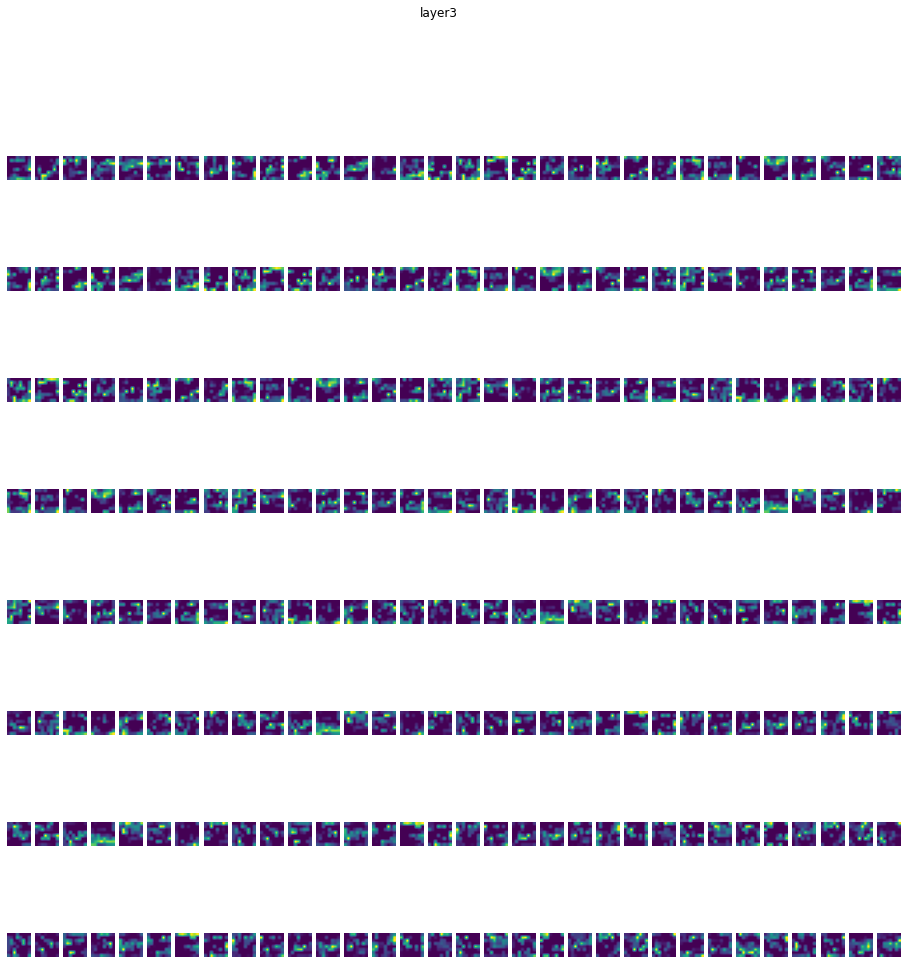

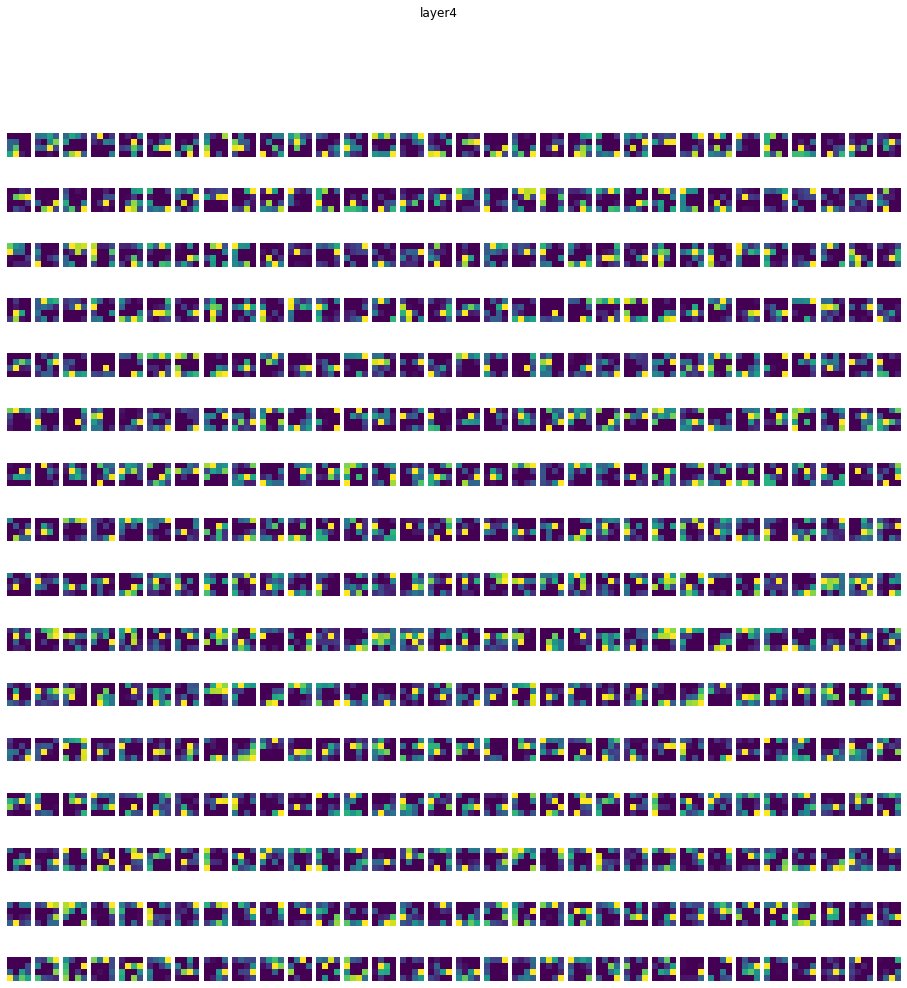

In [13]:
data_dir = './data'
transforms = create_transforms()
cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transforms['test'])

#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

model.eval()
with torch.no_grad():
  output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols, figsize=(16,16))
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')